In [1]:
from pyspark.sql import SparkSession
# Initialize SparkSession
spark = SparkSession.builder.appName("CropYieldAnalysis").getOrCreate()

# Load the CSV file
df = spark.read.csv("uncleaned_crop_yield.csv", header=True, inferSchema=False)
# Display initial data
print("Initial Data:")
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 23:40:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Initial Data:
+------+---------+-------+-----------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|   Crop|      Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+-------+-----------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|  West|    Sandy| Cotton|897.0772391101236| 27.676966373377603|          False|           True|           Cloudy|          122.0|     6.555816258223593|
| South|     Clay|   Rice|992.6732816189208|  18.02614225436302|           True|           True|          Rainy  |          140.0|       8.5273409063236|
| North|     Loam| Barley|147.9980252926104|  29.79404241557257|          False|          False|            Sunny|          106.0|                  NULL|
| noRTH|    Sandy|Soybean|986.8663313367324|  16.6441901913772

In [2]:
# Drop duplicate rows
df = df.dropDuplicates()

# Display schema and information about the DataFrame
print("DataFrame Info:")
df.printSchema()

# Show a summary of the DataFrame
print("Data Summary:")
df.describe().show()

DataFrame Info:
root
 |-- Region: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Rainfall_mm: string (nullable = true)
 |-- Temperature_Celsius: string (nullable = true)
 |-- Fertilizer_Used: string (nullable = true)
 |-- Irrigation_Used: string (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Days_to_Harvest: string (nullable = true)
 |-- Yield_tons_per_hectare: string (nullable = true)

Data Summary:


24/11/24 23:40:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------+----------+----------+------------------+-------------------+---------------+---------------+-----------------+------------------+----------------------+
|summary|  Region| Soil_Type|      Crop|       Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|   Days_to_Harvest|Yield_tons_per_hectare|
+-------+--------+----------+----------+------------------+-------------------+---------------+---------------+-----------------+------------------+----------------------+
|  count| 1000000|   1000000|   1000000|            950000|             950001|        1000000|        1000000|          1000000|            950000|                950000|
|   mean|    NULL|      NULL|      NULL| 550.0618088764759| 27.505919432850167|           NULL|           NULL|             NULL|104.49760736842106|     4.650397789424634|
| stddev|    NULL|      NULL|      NULL|259.98325221893145|  7.232755962223472|           NULL|           NULL|             NULL|25.95437186

In [3]:
from pyspark.sql.functions import col, sum

# Calculate the sum of null values for each column
null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Show the result
null_counts.show()

# List of columns to change datatype (all columns or specify desired ones)
columns_to_convert = ["Rainfall_mm", "Temperature_Celsius", "Yield_tons_per_hectare"]

# Convert columns from string to double
for col_name in columns_to_convert:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# Verify the schema after conversion
df.printSchema()


+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop|Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|     0|        0|   0|      50000|              49999|              0|              0|                0|          50000|                 50000|
+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+

root
 |-- Region: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_Celsius: double (nullable = true)
 |-- Fertilizer_Used: string (nullable = true)
 |-- Irrigati

In [4]:
# Handle missing values
# Fill numeric columns with their mean
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ("int", "double")]
for col_name in numeric_columns:
    mean_value = df.select(col_name).groupBy().avg(col_name).first()[0]
    df = df.fillna({col_name: mean_value})

# Fill categorical columns with a placeholder
categorical_columns = [col_name for col_name, dtype in df.dtypes if dtype == "string"]
df = df.fillna({col_name: "Unknown" for col_name in categorical_columns})

# Calculate the sum of null values for each column
null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Show the result
null_counts.show()

+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop|Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|     0|        0|   0|          0|                  0|              0|              0|                0|              0|                     0|
+------+---------+----+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+



In [5]:
from pyspark.sql.functions import trim

# Strip whitespace from string columns
for col_name in categorical_columns:
    df = df.withColumn(col_name, trim(col(col_name)))

# Display the DataFrame to verify the result
print("DataFrame after trimming whitespace from string columns:")
df.show(truncate=False)


DataFrame after trimming whitespace from string columns:
+------+---------+-------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop   |Rainfall_mm       |Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+-------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|North |Silt     |Soybean|199.38193686127573|24.40539970164948  |False          |False          |Rainy            |77.0           |2.094286585378294     |
|North |Clay     |Soybean|124.59555905272148|24.381639466718735 |False          |False          |Rainy            |125.0          |1.1297512768654394    |
|East  |Sandy    |Wheat  |983.47603209473   |28.71469155885488  |False          |False          |Cloudy           |104.0          |5.076176030917903     |
|West  |Loam 

In [6]:
from pyspark.sql.functions import when, upper, isnan

# Convert all string columns to uppercase
string_columns = [col_name for col_name, dtype in df.dtypes if dtype == "string"]
for col_name in string_columns:
    df = df.withColumn(col_name, upper(col(col_name)))

# Display a sample of the data after converting strings to uppercase
print("Sample data after converting strings to uppercase:")
df.show(5, truncate=False)

# Count null values for all columns after the transformation
null_counts_after_upper = (
    df.select([when(col(c).isNull() | isnan(c), 1).alias(c) for c in df.columns])
    .groupBy()
    .sum()
)

print("Null counts per column after converting strings to uppercase:")
null_counts_after_upper.show()

# Count the number of rows after the transformation
row_count_after_upper = df.count()
print(f"Number of rows after converting strings to uppercase: {row_count_after_upper}")

# Collect and display a sample of the processed data
processed_data_after_upper = df.take(5)  # Collect the first 5 rows
for row in processed_data_after_upper:
    print(row)


Sample data after converting strings to uppercase:


24/11/24 23:40:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+---------+-------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop   |Rainfall_mm       |Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+-------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|NORTH |SILT     |SOYBEAN|199.38193686127573|24.40539970164948  |FALSE          |FALSE          |RAINY            |77.0           |2.094286585378294     |
|NORTH |CLAY     |SOYBEAN|124.59555905272148|24.381639466718735 |FALSE          |FALSE          |RAINY            |125.0          |1.1297512768654394    |
|EAST  |SANDY    |WHEAT  |983.47603209473   |28.71469155885488  |FALSE          |FALSE          |CLOUDY           |104.0          |5.076176030917903     |
|WEST  |LOAM     |MAIZE  |966.013861462972  |30.05385797634982  |TRUE 

+-----------+--------------+---------+----------------+------------------------+--------------------+--------------------+----------------------+--------------------+---------------------------+
|sum(Region)|sum(Soil_Type)|sum(Crop)|sum(Rainfall_mm)|sum(Temperature_Celsius)|sum(Fertilizer_Used)|sum(Irrigation_Used)|sum(Weather_Condition)|sum(Days_to_Harvest)|sum(Yield_tons_per_hectare)|
+-----------+--------------+---------+----------------+------------------------+--------------------+--------------------+----------------------+--------------------+---------------------------+
|       NULL|          NULL|     NULL|            NULL|                    NULL|                NULL|                NULL|                  NULL|                NULL|                       NULL|
+-----------+--------------+---------+----------------+------------------------+--------------------+--------------------+----------------------+--------------------+---------------------------+

Number of rows after con

In [7]:
from pyspark.sql.functions import round

# Round the 'Rainfall_mm' column to 2 decimal places
df = df.withColumn("Rainfall_mm", round(col("Rainfall_mm"), 2))

# Display the updated DataFrame
df.show(5)

+------+---------+-------+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|   Crop|Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+-------+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
| NORTH|     SILT|SOYBEAN|     199.38|  24.40539970164948|          FALSE|          FALSE|            RAINY|           77.0|     2.094286585378294|
| NORTH|     CLAY|SOYBEAN|      124.6| 24.381639466718735|          FALSE|          FALSE|            RAINY|          125.0|    1.1297512768654394|
|  EAST|    SANDY|  WHEAT|     983.48|  28.71469155885488|          FALSE|          FALSE|           CLOUDY|          104.0|     5.076176030917903|
|  WEST|     LOAM|  MAIZE|     966.01|  30.05385797634982|           TRUE|          FALSE|           CLOUDY|    

In [8]:
from pyspark.sql.functions import col

# Identify numeric columns
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ("int", "double")]

# Loop through numeric columns to filter outliers
for col_name in numeric_columns:
    # Calculate Q1 and Q3 using approxQuantile
    Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], relativeError=0.01)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter rows within the bounds
    df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

# Show the DataFrame information
print("Filtered DataFrame:")
df.printSchema()
df.show()


Filtered DataFrame:
root
 |-- Region: string (nullable = false)
 |-- Soil_Type: string (nullable = false)
 |-- Crop: string (nullable = false)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_Celsius: double (nullable = false)
 |-- Fertilizer_Used: string (nullable = false)
 |-- Irrigation_Used: string (nullable = false)
 |-- Weather_Condition: string (nullable = false)
 |-- Days_to_Harvest: string (nullable = false)
 |-- Yield_tons_per_hectare: double (nullable = false)



+------+---------+-------+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|   Crop|Rainfall_mm|Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+-------+-----------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
| NORTH|     SILT|SOYBEAN|     199.38|  24.40539970164948|          FALSE|          FALSE|            RAINY|           77.0|     2.094286585378294|
| NORTH|     CLAY|SOYBEAN|      124.6| 24.381639466718735|          FALSE|          FALSE|            RAINY|          125.0|    1.1297512768654394|
|  EAST|    SANDY|  WHEAT|     983.48|  28.71469155885488|          FALSE|          FALSE|           CLOUDY|          104.0|     5.076176030917903|
|  WEST|     LOAM|  MAIZE|     966.01|  30.05385797634982|           TRUE|          FALSE|           CLOUDY|    

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType

# Define categorical columns to encode
categorical_columns = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition', 'Irrigation_Used', 'Fertilizer_Used']

# Remove existing index/encoded columns if present
columns_to_remove = [f"{col}_Index" for col in categorical_columns] + [f"{col}_Encoded" for col in categorical_columns]
df = df.drop(*[c for c in columns_to_remove if c in df.columns])

# Apply StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Index") for col_name in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col_name}_Index", outputCol=f"{col_name}_Encoded", dropLast=False) for col_name in categorical_columns]

# Combine into a pipeline
pipeline = Pipeline(stages=indexers + encoders)

# Fit and transform the DataFrame
pipeline_model = pipeline.fit(df)
encoded_df = pipeline_model.transform(df)

# Convert OneHotEncoded vectors to separate binary columns
def extract_dense_vector(vector, index):
    return float(vector[index]) if vector is not None else 0.0

for col_name in categorical_columns:
    num_categories = encoded_df.select(f"{col_name}_Encoded").first()[0].size  # Get number of categories
    for i in range(num_categories):
        extract_udf = udf(lambda vector: extract_dense_vector(vector, i), FloatType())
        encoded_df = encoded_df.withColumn(f"{col_name}_{i}", extract_udf(col(f"{col_name}_Encoded")))

# Drop original, indexed, and encoded columns
columns_to_drop = categorical_columns + [f"{col}_Index" for col in categorical_columns] + [f"{col}_Encoded" for col in categorical_columns]
encoded_df = encoded_df.drop(*columns_to_drop)

# Show the final DataFrame
encoded_df.show(truncate=False)
encoded_df.printSchema()


+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+------+------+------+------+-------------------+-------------------+-------------------+-----------------+-----------------+-----------------+-----------------+
|Rainfall_mm|Temperature_Celsius|Days_to_Harvest|Yield_tons_per_hectare|Region_0|Region_1|Region_2|Region_3|Soil_Type_0|Soil_Type_1|Soil_Type_2|Soil_Type_3|Soil_Type_4|Soil_Type_5|Crop_0|Crop_1|Crop_2|Crop_3|Crop_4|Crop_5|Weather_Condition_0|Weather_Condition_1|Weather_Condition_2|Irrigation_Used_0|Irrigation_Used_1|Fertilizer_Used_0|Fertilizer_Used_1|
+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+------+------+------+------+-------------------+-------------------+-------------------+--------

In [10]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, when

# Define the columns to scale
columns_to_convert = [ "Days_to_Harvest", "Yield_tons_per_hectare"]

# Replace null values with 0.0 and cast to double
for col_name in columns_to_convert:
    encoded_df = encoded_df.withColumn(col_name, when(col(col_name).isNull(), 0.0).otherwise(col(col_name).cast("double")))

# Define the columns to scale
columns_to_scale = ["Rainfall_mm", "Temperature_Celsius"]

# Replace null values with 0.0 and cast to double
for col_name in columns_to_scale:
    encoded_df = encoded_df.withColumn(
        col_name,
        when(col(col_name).isNull(), 0.0).otherwise(col(col_name).cast("double"))
    )

# Create a VectorAssembler to combine the columns into a single vector
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features_to_scale")

# Transform the DataFrame to add the 'features_to_scale' column
df = assembler.transform(encoded_df)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features_to_scale", outputCol="scaled_features")

# Fit and transform the scaler to scale the features
scaler_model = scaler.fit(df)
scaled_df = scaler_model.transform(df)

# Convert the vector column to an array to extract individual elements
scaled_df = scaled_df.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

# Extract the scaled features back into individual columns
for i, col_name in enumerate(columns_to_scale):
    scaled_df = scaled_df.withColumn(col_name + "_scaled", col("scaled_features_array")[i])

scaled_df = scaled_df.drop("features_to_scale", "scaled_features", "scaled_features_array")

# Show the resulting DataFrame
scaled_df.show(truncate=False)

# Print schema to verify new scaled columns
scaled_df.printSchema()


+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+------+------+------+------+-------------------+-------------------+-------------------+-----------------+-----------------+-----------------+-----------------+--------------------+--------------------------+
|Rainfall_mm|Temperature_Celsius|Days_to_Harvest|Yield_tons_per_hectare|Region_0|Region_1|Region_2|Region_3|Soil_Type_0|Soil_Type_1|Soil_Type_2|Soil_Type_3|Soil_Type_4|Soil_Type_5|Crop_0|Crop_1|Crop_2|Crop_3|Crop_4|Crop_5|Weather_Condition_0|Weather_Condition_1|Weather_Condition_2|Irrigation_Used_0|Irrigation_Used_1|Fertilizer_Used_0|Fertilizer_Used_1|Rainfall_mm_scaled  |Temperature_Celsius_scaled|
+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window_spec = Window.partitionBy("Region_0").orderBy(F.desc("Yield_tons_per_hectare"))
df = scaled_df.withColumn("Rank", F.rank().over(window_spec))
df.show()


+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+------+------+------+------+-------------------+-------------------+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+--------------------------+----+
|Rainfall_mm|Temperature_Celsius|Days_to_Harvest|Yield_tons_per_hectare|Region_0|Region_1|Region_2|Region_3|Soil_Type_0|Soil_Type_1|Soil_Type_2|Soil_Type_3|Soil_Type_4|Soil_Type_5|Crop_0|Crop_1|Crop_2|Crop_3|Crop_4|Crop_5|Weather_Condition_0|Weather_Condition_1|Weather_Condition_2|Irrigation_Used_0|Irrigation_Used_1|Fertilizer_Used_0|Fertilizer_Used_1|Rainfall_mm_scaled|Temperature_Celsius_scaled|Rank|
+-----------+-------------------+---------------+----------------------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+------+-

# Part 2

In [12]:
# Separate features (X) by dropping the target column
X = scaled_df.drop("Yield_tons_per_hectare")

# Select the target column (Y)
Y = scaled_df.select("Yield_tons_per_hectare")

# Show summary statistics for features
print("Feature Summary:")
X.describe().show()

# Show summary statistics for the target variable
print("Target Summary:")
Y.describe().show()

Feature Summary:


+-------+-----------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------------+
|summary|      Rainfall_mm|Temperature_Celsius|   Days_to_Harvest|           Region_0|           Region_1|           Region_2|           Region_3|        Soil_Type_0|        Soil_Type_1|        Soil_Type_2|       Soil_Type_3|        Soil_Type_4|        Soil_Type_5|             Crop_0|            Crop_1|             Crop_2|             Crop_3|             Crop_4|             Crop_5|Weather_Condition_0|Weather_Condition_1|Weather

+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                999492|
|   mean|    4.6499787462959095|
| stddev|    1.6507275776895394|
|    min|    -3.329789271009E-4|
|    max|     9.229147102173412|
+-------+----------------------+



In [13]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, when

# Ensure all feature columns have valid numeric data
feature_columns = [col for col in scaled_df.columns if col != "Yield_tons_per_hectare"]
for feature in feature_columns:
    scaled_df = scaled_df.withColumn(feature, when(col(feature).isNull(), 0.0).otherwise(col(feature).cast("double")))

# Combine features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dataset = assembler.transform(scaled_df).select("features", col("Yield_tons_per_hectare").alias("label"))

# Split the dataset into training and testing sets
train_df, test_df = dataset.randomSplit([0.8, 0.2], seed=42)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
print(train_df)
# Fit the scaler on the training set
scaler_model = scaler.fit(train_df)

# Transform the training and testing datasets
train_df = scaler_model.transform(train_df).select("scaled_features", "label")
test_df = scaler_model.transform(test_df).select("scaled_features", "label")

# Display the processed training dataset
train_df.show(truncate=False)


DataFrame[features: vector, label: double]


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                                                    

## Linear Regression

In [14]:
import time
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

start_time = time.time()

# Train Linear Regression model
linear_reg = LinearRegression(featuresCol="scaled_features", labelCol="label", predictionCol="prediction")
linear_model = linear_reg.fit(train_df)

# Predictions on the test data
predictions_lr = linear_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Test the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
mse = evaluator.evaluate(predictions_lr, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions_lr, {evaluator.metricName: "r2"})

print(f"Mean Squared Error (MSE): {mse}")
print(f"R Squared (R²): {r2}")
print(f"Training and prediction time: {training_and_prediction_time:.2f} seconds")


24/11/24 23:42:45 WARN Instrumentation: [872024dd] regParam is zero, which might cause numerical instability and overfitting.
24/11/24 23:43:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/24 23:43:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/24 23:43:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/11/24 23:43:11 WARN Instrumentation: [872024dd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Mean Squared Error (MSE): 0.4393387154159705
R Squared (R²): 0.8383751780946669
Training and prediction time: 52.40 seconds


## Generalized Linear Regression

In [15]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Init the Generalized Linear Regression (GLR) model
glr = GeneralizedLinearRegression(featuresCol="scaled_features",
                                  labelCol="label",
                                  predictionCol="prediction",
                                  family="gaussian",
                                  link="identity")

start_time = time.time()

# Fit the GLR model on the training dataset
glr_model = glr.fit(train_df)

# Make predictions on the test dataset
predictions_glr = glr_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Evaluate the model 
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calculate Mean Squared Error (MSE) and R-squared
mse = evaluator.evaluate(predictions_glr, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions_glr, {evaluator.metricName: "r2"})

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R Squared (R²): {r2}")
print(f"Training and prediction time: {training_and_prediction_time} seconds")

summary = glr_model.summary
print("\nModel Summary:")
print(f"Coefficients: {glr_model.coefficients}")
print(f"Intercept: {glr_model.intercept}")
print(f"Deviance Residuals: {summary.residuals().show(5)}")


24/11/24 23:44:52 WARN Instrumentation: [806803ef] regParam is zero, which might cause numerical instability and overfitting.
24/11/24 23:45:19 WARN Instrumentation: [806803ef] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Mean Squared Error (MSE): 0.4393387154159705
R Squared (R²): 0.8383751780946669
Training and prediction time: 29.863041877746582 seconds

Model Summary:
Coefficients: [0.6004698519033251,0.066680713889746,0.000119378848121419,0.0005698273972192073,-0.0006803730323474879,-0.00014238562259217017,0.0002525198436007639,7.221939460098705e-05,3.826409389888566e-05,-0.0004661103028056724,-0.0009629815785636846,0.0011211111885662522,0.00019879158844439762,-0.0005320544060167958,0.0012988313562074733,0.0003979183742742158,-0.00011598002517578517,-0.000353725777425368,-0.0006946083760137058,-0.00011779309513198488,0.0003234368706854362,-0.00020573020802903727,-0.28462390859481,0.28462390859481,-0.35632703394231596,0.35632703394231463,0.6004698519033135,0.06668071388974098]
Intercept: 4.648263150922243


+--------------------+
|   devianceResiduals|
+--------------------+
| -0.5027668861906587|
|   0.164476809127875|
|-0.27387473757513536|
| -0.3650045251623446|
|-0.28210714577041096|
+--------------------+
only showing top 5 rows

Deviance Residuals: None


## Decision Tree

In [16]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

start_time = time.time()

# Train a Decision Tree Regressor model
decision_tree_reg = DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label", predictionCol="prediction")
decision_tree_model = decision_tree_reg.fit(train_df)

# Make predictions on the test data
predictions_dt = decision_tree_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
mse = evaluator.evaluate(predictions_dt, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions_dt, {evaluator.metricName: "r2"})

print(f"Mean Squared Error (MSE): {mse}")
print(f"R Squared (R²): {r2}")
print(f"Training and prediction time: {training_and_prediction_time} seconds")

Mean Squared Error (MSE): 0.4809316251933282
R Squared (R²): 0.8230738936883402
Training and prediction time: 101.44391202926636 seconds


## Random Forest

In [17]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Random Forest Regressor
random_forest = RandomForestRegressor(featuresCol="scaled_features", labelCol="label", predictionCol="prediction",
                                      numTrees=20, maxDepth=5, seed=42)  

start_time = time.time()

# Train the Random Forest Regressor
rf_model = random_forest.fit(train_df)

# Predict on the test data
predictions_rf = rf_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calculate Mean Squared Error (MSE) and R-Squared (R²)
mse = evaluator.evaluate(predictions_rf, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions_rf, {evaluator.metricName: "r2"})

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R Squared (R²): {r2}")
print(f"Training and prediction time: {training_and_prediction_time} seconds")


Mean Squared Error (MSE): 0.5029987982017232
R Squared (R²): 0.8149557771138446
Training and prediction time: 94.95898008346558 seconds


## GBT Regression

In [18]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

start_time = time.time()

# Train a Gradient-Boosted Tree Regressor model
gbt_regressor = GBTRegressor(featuresCol="scaled_features", labelCol="label", predictionCol="prediction", maxIter=100)
gbt_model = gbt_regressor.fit(train_df)

# Make predictions on the test data
predictions_gbt = gbt_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
mse = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "r2"})

print(f"Mean Squared Error (MSE): {mse}")
print(f"R Squared (R²): {r2}")
print(f"Training and prediction time: {training_and_prediction_time} seconds")


24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
24/11/24 23:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1012.8 KiB
24/11/24 23:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1013.3 KiB
24/11/24 23:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
24/11/24 23:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1015.0 KiB
24/11/24 23:54:21 WAR

Mean Squared Error (MSE): 0.4427175853863043
R Squared (R²): 0.8371321525245681
Training and prediction time: 164.66105604171753 seconds


## Elastic Net Regression

In [19]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the ElasticNet model
elasticNet = LinearRegression(featuresCol="scaled_features", labelCol="label", 
                              maxIter=10, regParam=0.3, elasticNetParam=0.8)

start_time = time.time()

# Fit the model to the data
elastic_model = elasticNet.fit(train_df)

# Make predictions
predictions_em = elastic_model.transform(test_df)

training_and_prediction_time = time.time() - start_time

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_em)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions_em)
print("R-squared (R²) on test data = %g" % r2)
print(f"Training and prediction time: {training_and_prediction_time} seconds")

Root Mean Squared Error (RMSE) on test data = 0.802309


R-squared (R²) on test data = 0.763195
Training and prediction time: 65.98604679107666 seconds


In [20]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(predictions, model_name):
    # Convert to Pandas DataFrame for plotting
    pandas_df = predictions.select('prediction', 'label').toPandas()
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.scatter(pandas_df['prediction'], pandas_df['label'], color='green', alpha=0.5)
    plt.plot([pandas_df['label'].min(), pandas_df['label'].max()], [pandas_df['label'].min(), pandas_df['label'].max()], 'k--', lw=4)
    plt.xlabel('Predicted Yield')
    plt.ylabel('Actual Yield')
    plt.title(f'Actual vs. Predicted for {model_name}')
    plt.show()

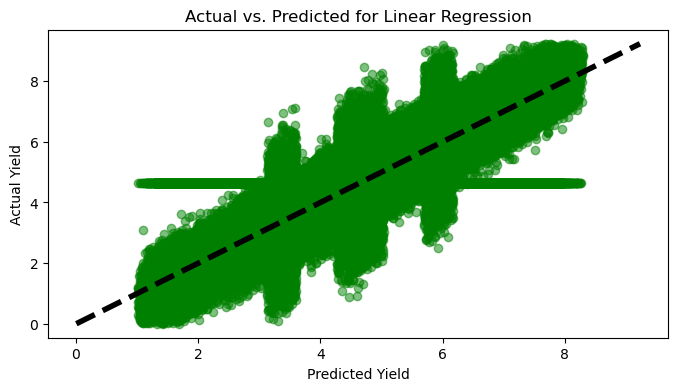

In [21]:
# Assume 'predictions_lr' is the predictions DataFrame from Linear Regression
plot_actual_vs_predicted(predictions_lr, 'Linear Regression')

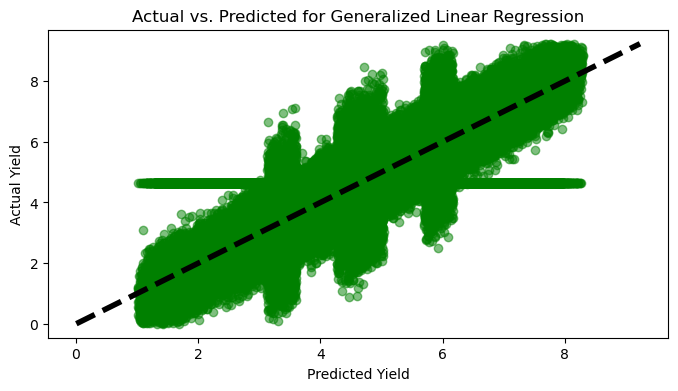

In [22]:
# Assume 'predictions_glr' is from Generalized Linear Regression
plot_actual_vs_predicted(predictions_glr, 'Generalized Linear Regression')

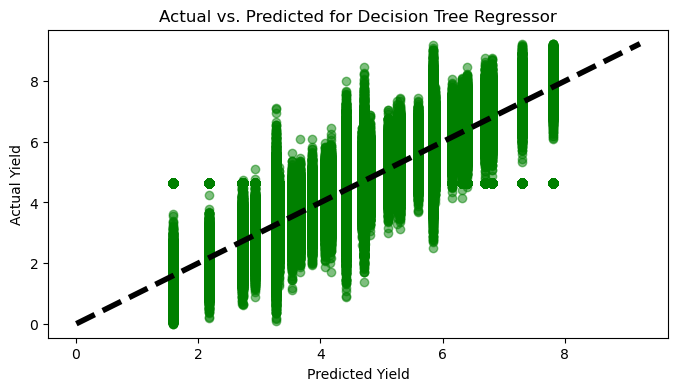

In [23]:
# Assume 'predictions_dtr' is from Decision Tree Regressor
plot_actual_vs_predicted(predictions_dt, 'Decision Tree Regressor')

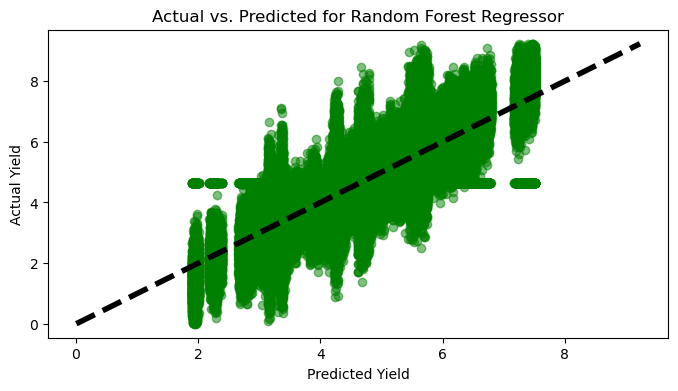

In [24]:
# Assume 'predictions_rfr' is from Random Forest Regressor
plot_actual_vs_predicted(predictions_rf, 'Random Forest Regressor')

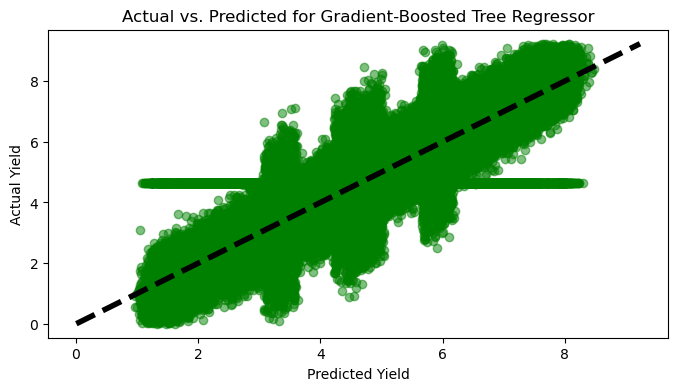

In [25]:
# Assume 'predictions_gbt' is from Gradient-Boosted Tree Regressor
plot_actual_vs_predicted(predictions_gbt, 'Gradient-Boosted Tree Regressor')

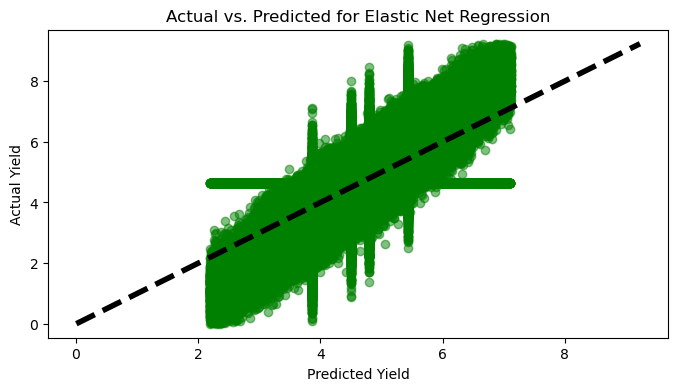

In [26]:
# Print the coefficients and intercept of the model
plot_actual_vs_predicted(predictions_em, 'Elastic Net Regression')

In [27]:
def plot_residuals_histogram(predictions, model_name):
    # Calculate residuals and convert to Pandas DataFrame
    predictions = predictions.withColumn("residual", col("label") - col("prediction"))
    pandas_df = predictions.select("residual").toPandas()
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.hist(pandas_df['residual'], bins=30, color='blue', alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals for {model_name}')
    plt.show()

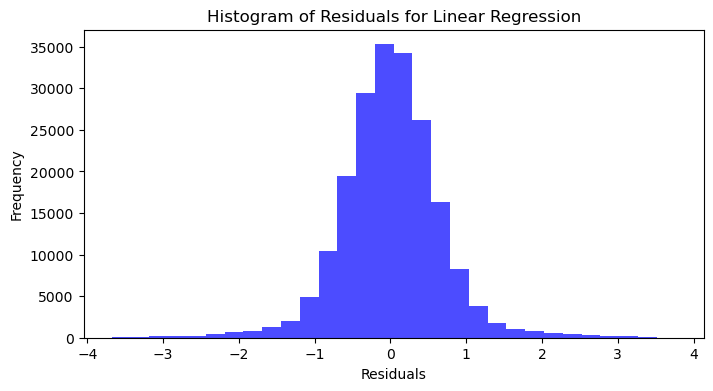

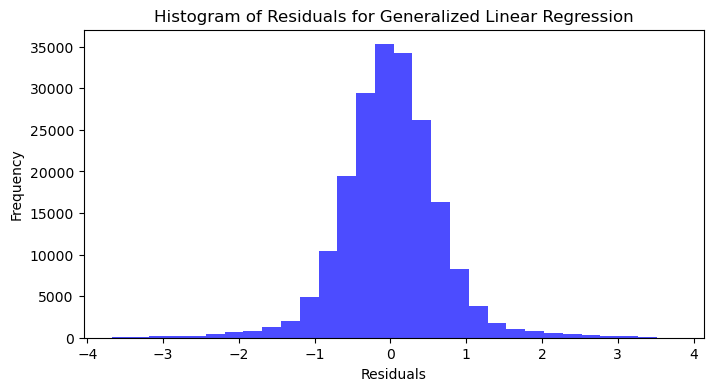

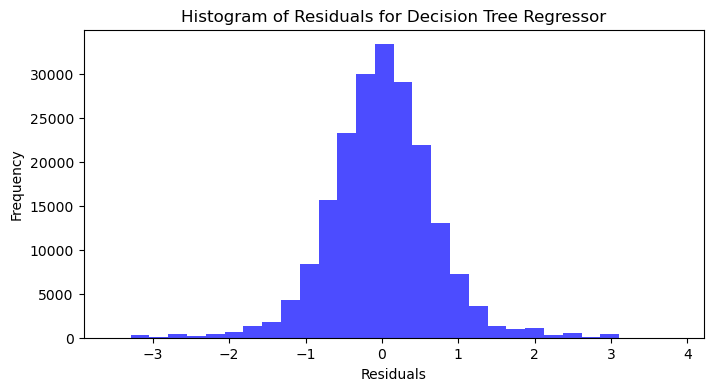

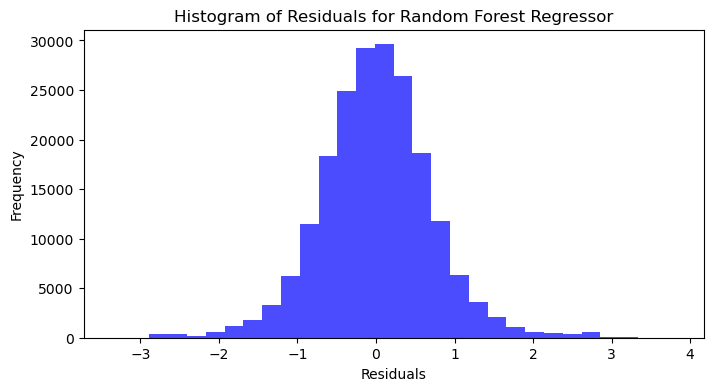

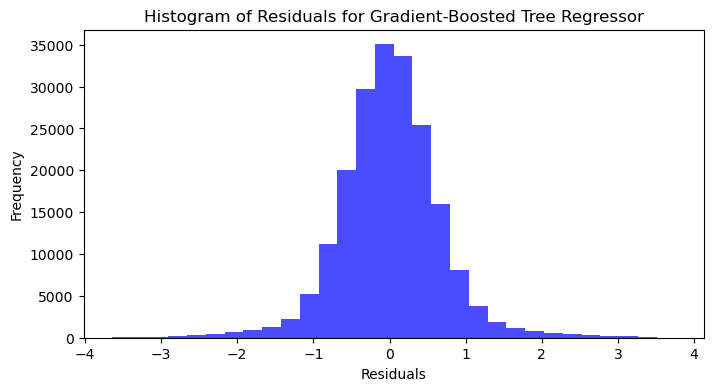

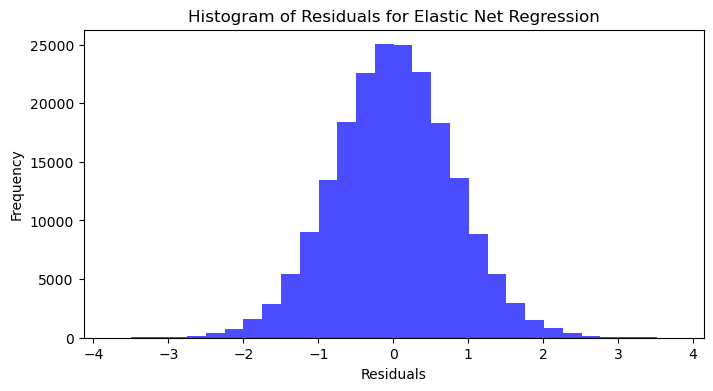

In [29]:
# Assuming you have the respective DataFrame for each model's predictions
plot_residuals_histogram(predictions_lr, "Linear Regression")
plot_residuals_histogram(predictions_glr, "Generalized Linear Regression")
plot_residuals_histogram(predictions_dt, "Decision Tree Regressor")
plot_residuals_histogram(predictions_rf, "Random Forest Regressor")
plot_residuals_histogram(predictions_gbt, "Gradient-Boosted Tree Regressor")
plot_residuals_histogram(predictions_em, "Elastic Net Regression")